In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GRU, Bidirectional, LSTM

In [3]:
# all_rmse = []

In [ ]:
# def rms_energy(signal, frame_length, hop_length):
#     rms_energy = []
    
#     for i in range(0, len(signal), hop_length):
#         rms_energy_current_frame = np.sqrt(np.sum(signal[i : i+frame_length]**2 / frame_length))
#         rms_energy.append(rms_energy_current_frame)
        
#     return np.array(rms_energy)

In [3]:
FRAME_SIZE = 256
HOP_LENGTH = 128
frame_size = FRAME_SIZE
hop_length = HOP_LENGTH
num_classes = 5

In [4]:
mood = 'aggressive dramatic happy romantic sad'.split()
emotion = []
# i = 1
for m in mood:
    for filename in os.listdir(f'/kaggle/input/music-classification/dataset/{m}'):
#         songname = f'/kaggle/input/music-classification/dataset/{m}/{filename}'
#         sig, sr = librosa.load(songname, mono=True, duration=5)
#         all_rmse.append(rms_energy(sig, frame_size, hop_length))
        emotion.append(m)
    print(f'Loading completed for {m}')

Loading completed for aggressive
Loading completed for dramatic
Loading completed for happy
Loading completed for romantic
Loading completed for sad


In [5]:
len(emotion)

10133

In [ ]:
# # Method 1
# import csv
# with open('rmse.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerows(all_rmse)

In [7]:
data = pd.read_csv('../input/root-mean-square-energy-csv/rmse.csv')
data.columns

Index(['0.53037494', '0.5964152', '0.620189', '0.5473993', '0.61540973',
       '0.568879', '0.5982697', '0.5769176', '0.58987623', '0.5820104',
       ...
       '0.30981848', '0.30007896', '0.29570857', '0.22462587', '0.18433389',
       '0.32372826', '0.32618374', '0.33356342', '0.28884664', '0.05533167'],
      dtype='object', length=862)

In [8]:
c = [str(i) for i in range(862)]
data.columns = c

In [9]:
data.shape

(10132, 862)

In [10]:
emotion = emotion[1:]

In [11]:
encoder = LabelEncoder()
y = encoder.fit_transform(emotion)#Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data, dtype = float))#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

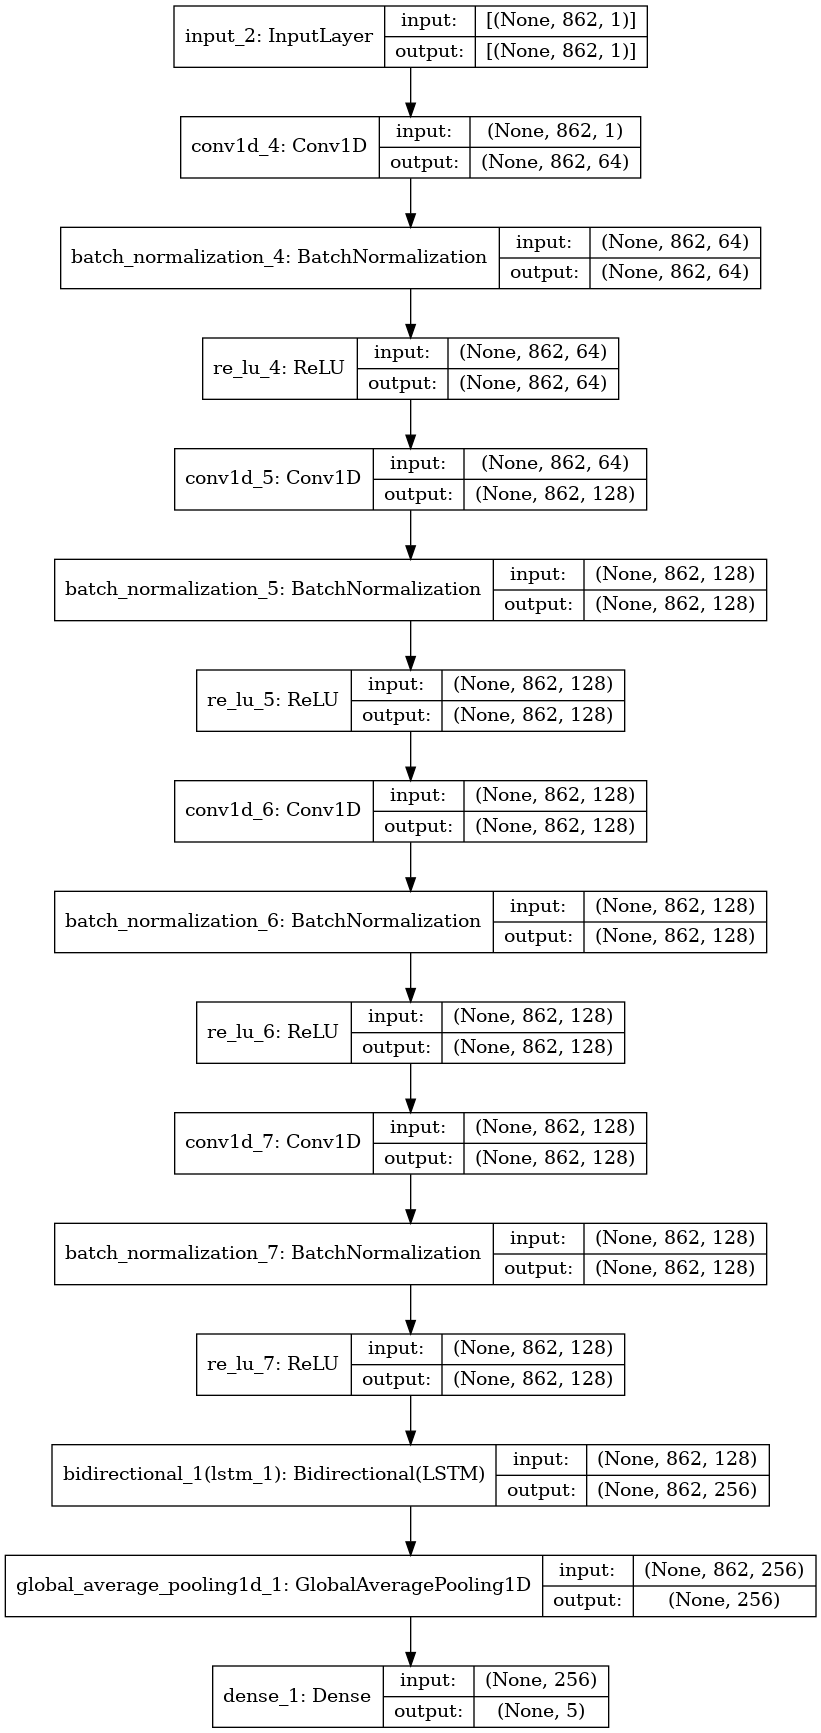

In [14]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    
    conv4 = keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(conv3)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.ReLU()(conv4)
    
    blstm1 = Bidirectional(LSTM(128, return_sequences=True))(conv4) #200 total units

    gap = keras.layers.GlobalAveragePooling1D()(blstm1)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [15]:
epochs = 200
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_rmse_final.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

# learn_rate=0.001
# sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy', 'mse', 'categorical_accuracy', 'accuracy'],
#     , 'Precision', 'Recall', 'AUC', 
#              'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'accuracy'],
)

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

# epochs = 1000
# batch_size = 32

# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         "best_model.h5", save_best_only=True, monitor="val_loss"
#     ),
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
#     ),
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
# ]
# model.compile(
#     optimizer="adam",
#     loss="sparse_categorical_crossentropy",
#     metrics=["sparse_categorical_accuracy"],
# )
# history = model.fit(
#     X_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     callbacks=callbacks,
#     validation_split=0.2,
#     verbose=1,
# )

Epoch 1/200
203/203 [==============================] - 31s 105ms/step - loss: 1.5857 - sparse_categorical_accuracy: 0.2610 - mse: 4.9192 - categorical_accuracy: 0.1282 - accuracy: 0.2610 - val_loss: 1.7734 - val_sparse_categorical_accuracy: 0.1869 - val_mse: 4.8798 - val_categorical_accuracy: 0.0000e+00 - val_accuracy: 0.1869
Epoch 2/200
203/203 [==============================] - 20s 99ms/step - loss: 1.5181 - sparse_categorical_accuracy: 0.2981 - mse: 4.8487 - categorical_accuracy: 0.1874 - accuracy: 0.2981 - val_loss: 1.5919 - val_sparse_categorical_accuracy: 0.2721 - val_mse: 4.8755 - val_categorical_accuracy: 0.0450 - val_accuracy: 0.2721
Epoch 3/200
203/203 [==============================] - 20s 99ms/step - loss: 1.4892 - sparse_categorical_accuracy: 0.3234 - mse: 4.7545 - categorical_accuracy: 0.2267 - accuracy: 0.3234 - val_loss: 1.4951 - val_sparse_categorical_accuracy: 0.3276 - val_mse: 4.8753 - val_categorical_accuracy: 0.0765 - val_accuracy: 0.3276
Epoch 4/200
203/203 [=====

In [16]:
model = keras.models.load_model("best_model_rmse_final.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

64/64 [==============================] - 3s 36ms/step - loss: 0.7815 - sparse_categorical_accuracy: 0.6724 - mse: 4.9521 - categorical_accuracy: 0.1865 - accuracy: 0.6724


ValueError: too many values to unpack (expected 2)

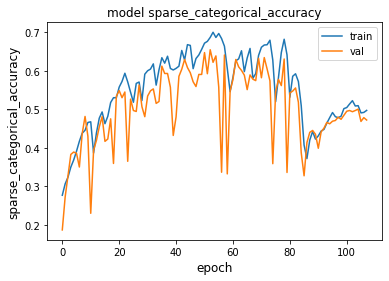

In [17]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

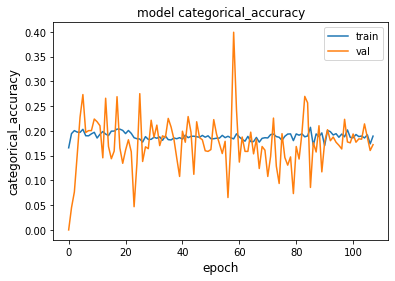

In [18]:
metric = "categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

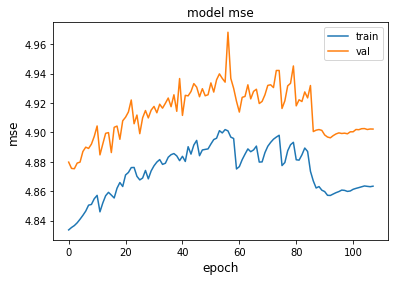

In [19]:
metric = "mse"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

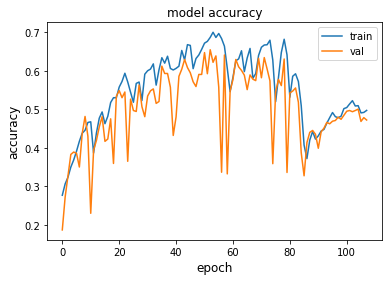

In [20]:
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
# metric = "AUC"
# plt.figure()
# plt.plot(history.history[metric])
# plt.plot(history.history["val_" + metric])
# plt.title("model " + metric)
# plt.ylabel(metric, fontsize="large")
# plt.xlabel("epoch", fontsize="large")
# plt.legend(["train", "val"], loc="best")
# plt.show()
# plt.close()

In [ ]:
# metric = "TruePositives"
# plt.figure()
# plt.plot(history.history[metric])
# plt.plot(history.history["val_" + metric])
# plt.title("model " + metric)
# plt.ylabel(metric, fontsize="large")
# plt.xlabel("epoch", fontsize="large")
# plt.legend(["train", "val"], loc="best")
# plt.show()
# plt.close()

In [ ]:
# metric = "TrueNegatives"
# plt.figure()
# plt.plot(history.history[metric])
# plt.plot(history.history["val_" + metric])
# plt.title("model " + metric)
# plt.ylabel(metric, fontsize="large")
# plt.xlabel("epoch", fontsize="large")
# plt.legend(["train", "val"], loc="best")
# plt.show()
# plt.close()

In [ ]:
# metric = "FalsePositives"
# plt.figure()
# plt.plot(history.history[metric])
# plt.plot(history.history["val_" + metric])
# plt.title("model " + metric)
# plt.ylabel(metric, fontsize="large")
# plt.xlabel("epoch", fontsize="large")
# plt.legend(["train", "val"], loc="best")
# plt.show()
# plt.close()

In [ ]:
# metric = "FalseNegatives"
# plt.figure()
# plt.plot(history.history[metric])
# plt.plot(history.history["val_" + metric])
# plt.title("model " + metric)
# plt.ylabel(metric, fontsize="large")
# plt.xlabel("epoch", fontsize="large")
# plt.legend(["train", "val"], loc="best")
# plt.show()
# plt.close()

In [ ]:
# metric = "CategoricalAccuracy"
# plt.figure()
# plt.plot(history.history[metric])
# plt.plot(history.history["val_" + metric])
# plt.title("model " + metric)
# plt.ylabel(metric, fontsize="large")
# plt.xlabel("epoch", fontsize="large")
# plt.legend(["train", "val"], loc="best")
# plt.show()
# plt.close()